 ## net_sim_mp.ipynb

This notebook is a template to run multiprocess simulations using the ei_network class.  

The particular network being build and simulated under different variations is that from step1.ipynb part 2.


By `Sergio Verduzco`  
June 2018

In [1]:
# import the ei_network class and draculab
%cd ..
#from ei_network import * # this loads non-cythonized module
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from ei_network import *

In [4]:
# This is the name of the file where logging will happen
log_file = "./logs/mp_net" + time.strftime("_%m-%d-%y.txt")

In [5]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [6]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [3]:
#~~~~~~~~~~~~ mp_net_runner object specification ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        """
        self.name = 'sig_trdc_test1'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 13  # one per network is good
        self.n_nets = 13
        self.n_pres = [70]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
                                          # currently it's 0 for sharpening, and 1 for non-sharpening
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        
        # One way to continue simulations. Replace the rest of __init__() with this:
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
        dill_obj = dill.load(F)
        self.nets = dill_obj.nets
        F.close()
        del dill_obj 
        """
        
        #layers =  ['L', 'shrp','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        layers =  ['L','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('It is testing networks of sig_trdc units, trying to improve the rate distribution in the')
            net.annotate('otherwise very good parameters from a simulation logged in step1p2_07/20/18.txt .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sig_trdc)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .0)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'n_ports', 2)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .01)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})            
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            #L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 1)
        #----------------------------------
            #L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.8)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./40.)
            L.set_param('ie_syn', 'des_act', 0.4)  
        #----------------------------------
            L.annotate("Using static EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.static)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
         #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 1)
            net.set_param('I1x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I1x_Le_syn', 'lrate', 1./100.)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 1)
            net.set_param('I2x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I2x_Le_syn', 'lrate', 1./100.)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> Reducing EE omega value")
        L.set_param('ee_syn', 'omega', 1.5)
        ### network 2
        n = 2
        L = self.nets[n].layers['L']
        L.annotate(">>> Reducing des_act in corr_homeo_inhib IE synapses")
        L.set_param('ie_syn', 'des_act', 0.2)
        ### network 3
        n = 3
        L = self.nets[n].layers['L']
        L.annotate(">>> Reducing EE omega value and des_act in corr_homeo_inhib IE synapses")
        L.set_param('ee_syn', 'omega', 1.5)
        L.set_param('ie_syn', 'des_act', 0.2)  # originally wrong (used 'e_pars')
        ### Network 4
        n = 4
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller EE omega and IE des_act, larger input weights")
        self.nets[n].set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        self.nets[n].set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        L.set_param('ee_syn', 'omega', 1.5)
        L.set_param('ie_syn', 'des_act', 0.2)  # originally wrong (used 'e_pars')
        ### Network 5
        n = 5
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller EE omega and IE des_act, larger input weights, slow EE plasticity")
        self.nets[n].set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        self.nets[n].set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        L.set_param('ee_syn', 'omega', 1.5)
        L.set_param('ie_syn', 'des_act', 0.2)
        L.set_param('ee_syn', 'lrate', 1./2000.)
        ### Network 6
        n = 6
        L = self.nets[n].layers['L']
        L.annotate(">>> Using covariance EI synapses")
        L.set_param('ei_syn', 'type', synapse_types.cov)
        L.set_param('ei_syn', 'lrate', 1./100.)
        ### Network 7
        n = 7
        L = self.nets[n].layers['L']
        L.annotate(">>> Removing EE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        ### Network 8
        n = 8
        L = self.nets[n].layers['L']
        L.annotate(">>> static input synapses")
        self.nets[n].set_param('I1x_Le_syn', 'type', synapse_types.static)
        self.nets[n].set_param('I2x_Le_syn', 'type', synapse_types.static)
        ### Network 9
        n = 9
        L = self.nets[n].layers['L']
        L.annotate(">>> Faster tau_thr")
        L.set_param('e_pars', 'tau_thr', .03)
        ### Network 10
        n = 10
        L = self.nets[n].layers['L']
        L.annotate(">>> Slower tau_thr")
        L.set_param('e_pars', 'tau_thr', .005)
        ### Network 11
        n = 11
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 12
        n = 12
        L = self.nets[n].layers['L']
        L.annotate("Setting c=2 for the rate distro")
        L.set_param('e_pars', 'c', 2.)
        
        self.build()
        """            
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I1
        if random:
            if pres < self.perm_switch[net_id]:
                idx = np.random.randint(n_pat)
            else:
                idx = self.idx_list1[pres%len(self.idx_list1)]
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def inp_pat2(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I2
        if random:
            if pres < self.perm_switch[net_id]:
                idx = np.random.randint(n_pat)
            else:
                idx = self.idx_list2[pres%len(self.idx_list2)]
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def make_I1_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat1(pres, rows, columns, net_id, n_pat, random=rnd) 
    
    def make_I2_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat2(pres, rows, columns, net_id, n_pat, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # patterns for L.x
        n_pat0 = 4  # number of input patterns
        self.pat_arr0 = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns
        for row in range(5):
            for col in range(5):
                idx = 5*col + row
                if row == col or row+col == 4: # The X input pattern
                    self.pat_arr0[0,idx] = 1
                if row == 2 or col == 2:  # The + input pattern
                    self.pat_arr0[1,idx] = 1
                if row == 1 or row == 3:  # The = input pattern
                    self.pat_arr0[2,idx] = 1
                if col == 1 or col == 3:  # The || input pattern
                    self.pat_arr0[3,idx] = 1
        self.pat_arr0 = self.pat_arr0 / 5.
        
        self.idx_list1 = [] # list with indexes of permuted input patterns for I1
        self.idx_list2 = [] # list with indexes of permuted input patterns for I2
        self.perm_switch = [] #perm_sitch[idx] = presentation when permuted inputs start for net idx
        
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            #shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units
            
            # preparing vectors with all the inputs in permuted order. Used by the inp_patX methods.
            # The purpose is that at the end of the simulation all inputs are shown.
            i_nums = np.random.permutation(n_pat1*n_pat2)
            self.idx_list1 = [int(np.floor(n/n_pat2)) for n in i_nums]
            self.idx_list2 = [int(round(n%n_pat2)) for n in i_nums]
            self.perm_switch.append(max(self.n_pres[idx]-(n_pat1*n_pat2), 0))
            
            if self.input_type[idx] == 0:  # for sharpening units
                shrp_inp_pat = lambda p, r, c, n : (1., 1)
                inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True), 
                                'shrp' : shrp_inp_pat }
                inp_fun_dic = {'shrp' : self.set_shrp_fun }
            elif self.input_type[idx] == 1: # for non-sharpening units
                inp_pat_dic = { #'L' : self.inp_pat0,
                                'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True) } 
                inp_fun_dic = {}
            else:
                raise ValueError('Invalid input type for network ' + str(idx))
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0):
        """ Simple analysis of the relation between inputs and outputs."""
        ei_net = self.nets[net_num]
        pats1 = ei_net.inp_hist['I1']
        pats2 = ei_net.inp_hist['I2']
        n_pat1 = ei_net.layers['I1'].n['x']
        n_pat2 = ei_net.layers['I2'].n['x']
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = ei_net.layers['L']
        inp_pat1 = self.make_I1_inp(n_pat1, False)
        inp_pat2 = self.make_I2_inp(n_pat2, False)

        ## For each input presentation obtain the activity vector from layer L
        ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]
    
        # The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
        pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
        n_pats = len(pats)
        pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
        for p in range(n_pres):
            p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
            pats[p_id] += 1
            pres_pat[p] = p_id
    
        # get the mean of output patterns corresponding to the same inputs
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        for pres in range(n_pres):
            mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
        for pat in range(n_pats):
            if pats[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
        # Obtain the dot products between any two pairs of input patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
                (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        fig2 = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
        plt.title('all runs')
    
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
        print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
        print("norm of difference between matrices: %f" % (diff_norm))
                                
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [5]:
#~~~~~~~~~~~~ mp_net_runner object specification with a D unit ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        """
        self.name = 'sig_trdc_test4'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 13  # one per network is good
        self.n_nets = 13
        self.n_pres = [100]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
                                          # currently it's 0 for sharpening, and 1 for non-sharpening
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        #"""
        # One way to continue simulations. Replace the rest of __init__() with this:
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        F = open("/home/z/projects/draculab/sig_trdc_test4.pkl", 'rb')
        dill_obj = dill.load(F)
        self.nets = dill_obj.nets
        self.input_list = dill_obj.input_list
        self.code = dill_obj.code
        F.close()
        del dill_obj 
        
        # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        # D is the delta unit, upd signals plasticity updates to D, des is the desired output of D.
        #layers =  ['L', 'shrp','I1', 'I2', 'D', 'upd', 'des']  
        layers =  ['L','I1', 'I2', 'D', 'upd', 'des'] 
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('It is testing networks of sig_trdc units, trying to improve the rate distribution in the')
            net.annotate('otherwise very good parameters from a simulation logged in step1p2_07/20/18.txt .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            D = net.layers['D']
            upd = net.layers['upd']
            des = net.layers['des']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sig_trdc)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .0)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'n_ports', 2)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .01)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})            
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            #L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 1)
        #----------------------------------
            #L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.8)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./40.)
            L.set_param('ie_syn', 'des_act', 0.4)  
        #----------------------------------
            L.annotate("Using static EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.static)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        # Delta unit parameters
        #----------------------------------
            utype_D = unit_types.delta_linear
            D.set_param('e_pars', 'type', utype_D)
            D.set_param('e_pars', 'n_ports', 3)
            D.set_param('e_pars', 'tau_slow', 10.)
            D.set_param('e_pars', 'tau_fast', 0.02)
            D.set_param('e_pars', 'gain', 2.)
            D.set_param('e_pars', 'tau_e', .7) # gives roughly 0.5 seconds
            D.set_param('e_pars', 'bias_lrate', .01)
        #----------------------------------
            #D.annotate("Adjusting size of e,i groups.")
            D.set_param('e_geom', 'rows', 1)
            D.set_param('e_geom', 'columns', 1)
            D.set_param('i_geom', 'rows', 0)
            D.set_param('ee_conn', 'weights',{'uniform' : {'low': 0., 'high' : 0.}})
            D.set_param('ee_conn', 'allow_autapses', False)
        #----------------------------------
            #D.annotate("Setting input parameters")
            D.set_param('x_geom', 'rows', 0) 
            D.set_param('x_geom', 'columns', 0) 
        #----------------------------------
            #upd.annotate("Leaving a single input unit in the upd layer")
            upd.set_param('e_geom', 'rows', 0)
            upd.set_param('i_geom', 'rows', 0)
            upd.set_param('x_geom', 'rows', 1)
            upd.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #upd.annotate("Configuring upd unit")
            upd.set_param('x_pars', 'function', lambda x : None)
            upd.set_param('x_pars', 'init_val', 1.)
            upd.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            #des.annotate("Leaving a single input unit in the des layer")
            des.set_param('e_geom', 'rows', 0)
            des.set_param('i_geom', 'rows', 0)
            des.set_param('x_geom', 'rows', 1)
            des.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #des.annotate("Configuring des unit")
            des.set_param('x_pars', 'function', lambda x : None)
            des.set_param('x_pars', 'init_val', 1.)
            des.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            D.set_param('n', 'w_track', 0)
            upd.set_param('n', 'w_track', 0)
            des.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
            net.add_connection(('L','e'), ('D','e'))
            net.add_connection(('upd','x'), ('D','e'))
            net.add_connection(('des','x'), ('D','e'))
         #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 1)
            net.set_param('I1x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I1x_Le_syn', 'lrate', 1./100.)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 1)
            net.set_param('I2x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I2x_Le_syn', 'lrate', 1./100.)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
            net.set_param('Le_De_conn', 'connection_type', 'divergent')
            net.set_param('Le_De_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_De_conn', 'kernel', 1.)
            net.set_param('Le_De_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .05}})
            net.set_param('Le_De_syn', 'inp_ports', 0)
            net.set_param('Le_De_syn', 'type', synapse_types.delta)
            net.set_param('Le_De_syn', 'lrate', .03)

            net.set_param('updx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('updx_De_conn', 'kernel', 1.)
            net.set_param('updx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('updx_De_syn', 'inp_ports', 2)

            net.set_param('desx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('desx_De_conn', 'kernel', 1.)
            net.set_param('desx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('desx_De_syn', 'inp_ports', 1)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> Reducing EE omega value")
        L.set_param('ee_syn', 'omega', 1.5)
        ### network 2
        n = 2
        L = self.nets[n].layers['L']
        L.annotate(">>> Reducing des_act in corr_homeo_inhib IE synapses")
        L.set_param('ie_syn', 'des_act', 0.2)
        ### network 3
        n = 3
        L = self.nets[n].layers['L']
        L.annotate(">>> Reducing EE omega value and des_act in corr_homeo_inhib IE synapses")
        L.set_param('ee_syn', 'omega', 1.5)
        L.set_param('ie_syn', 'des_act', 0.2)  # originally wrong (used 'e_pars')
        ### Network 4
        n = 4
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller EE omega and IE des_act, larger input weights")
        self.nets[n].set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        self.nets[n].set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        L.set_param('ee_syn', 'omega', 1.5)
        L.set_param('ie_syn', 'des_act', 0.2)  # originally wrong (used 'e_pars')
        ### Network 5
        n = 5
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller EE omega and IE des_act, larger input weights, slow EE plasticity")
        self.nets[n].set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        self.nets[n].set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.3, 'high' : 1.}})
        L.set_param('ee_syn', 'omega', 1.5)
        L.set_param('ie_syn', 'des_act', 0.2)
        L.set_param('ee_syn', 'lrate', 1./2000.)
        ### Network 6
        n = 6
        L = self.nets[n].layers['L']
        L.annotate(">>> Using covariance EI synapses")
        L.set_param('ei_syn', 'type', synapse_types.cov)
        L.set_param('ei_syn', 'lrate', 1./100.)
        ### Network 7
        n = 7
        L = self.nets[n].layers['L']
        L.annotate(">>> Removing EE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        ### Network 8
        n = 8
        L = self.nets[n].layers['L']
        L.annotate(">>> static input synapses")
        self.nets[n].set_param('I1x_Le_syn', 'type', synapse_types.static)
        self.nets[n].set_param('I2x_Le_syn', 'type', synapse_types.static)
        ### Network 9
        n = 9
        L = self.nets[n].layers['L']
        L.annotate(">>> Faster tau_thr")
        L.set_param('e_pars', 'tau_thr', .03)
        ### Network 10
        n = 10
        L = self.nets[n].layers['L']
        L.annotate(">>> Slower tau_thr")
        L.set_param('e_pars', 'tau_thr', .005)
        ### Network 11
        n = 11
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 12
        n = 12
        L = self.nets[n].layers['L']
        L.annotate("Setting c=2 for the rate distro")
        L.set_param('e_pars', 'c', 2.)
        
        self.build()
        #"""            
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I1. """
        if random:  
            idx = self.input_list[pres][0] # a list of randomly permuted inputs, from input_config
        else:
            idx = pres % n_pat1
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def inp_pat2(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I2. """
        if random:  
            idx = self.input_list[pres][1]
        else:
            idx = pres % n_pat2
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)
    
    def des_fun(self, I1, I2):
        """ The function that produces the des input pattern from the I1 and I2 input patterns. """
        return (I1 + I2)/self.max_inp_sum

    def make_I1_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat1 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat1(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I2_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat2 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat2(pres, n_pat1, n_pat2, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time):
        """ Returns a function that goes from 1 to 0 when its argument is close to init_time or init_time+pres_time.
            
            Args:
                prev_pat : 1-D numpy array with the previous input pattern. (not currently used)
                cur_pat : 1-D numpy array with the current input pattern. (not currently used)
                init_time: initial time of this presentation.
                pres_time: duration of this presentation.
        """
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the sharpening function on the given input units using make_shrp_fun. """
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time) )

    def make_upd_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        """ Returns the function for update inputs to delta units. """
        eps = .5 # update is started eps units before the next input
        #return lambda t: 1.  # constantly updating unit
        return lambda t : 1. if (t > init_time+pres_time-eps and t < init_time+pres_time-eps/2.) else 0.
        
    def set_upd_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the update functions on the given inp_units. """
        for unit in inp_units:
            unit.set_function( self.make_upd_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def des_pat(self, pres, n_inp):
        """ The function that creates the desired pattern for delta units. """
        #p = pres%n_inp
        idx = self.input_list[pres][2]
        return ([idx], int(self.max_inp_sum*idx))
    
    def make_des_pat(self, n_inp):
        """ Uses des_pat() to create a target function. """
        return lambda pres, rows, columns, n_id: self.des_pat(pres, n_inp)

    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # Generate input pattern list for I layers
        if not hasattr(self, 'input_list'):
            self.input_list = [] # will contain 3-tuples with all the input indexes (I1x,I2x,desx)        
        nprs = max(self.n_pres) # how many input patterns to generate
        np1 = self.nets[0].layers['I1'].n['x'] # assuming all networks have same input geometry!!!
        np2 = self.nets[0].layers['I2'].n['x']
        self.max_inp_sum = np1+np2 # used by des_fun to normalize the input sum
        n_inp = np1*np2
        for epoch in range(int(np.floor(nprs/n_inp))): # we present all patterns in one full epoch
            aux_list = []
            for p1 in range(np1):
                for p2 in range(np2):
                    aux_list.append( (p1, p2, self.des_fun(p1,p2)) ) 
            np.random.shuffle(aux_list)
            self.input_list += aux_list
        rem_inps = int(np.round(nprs%n_inp)) # inputs constituting just part of an epoch
        pat_ids = np.random.choice(range(n_inp), rem_inps, replace=False)
        for pid in pat_ids:
            p1 = int(np.floor(pid/np2))
            p2 = int(round(pid%np2))
            self.input_list.append( ( p1, p2, self.des_fun(p1,p2) ) ) 
        # Create input pattern dictionaries and append them to the lists
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units     
            shrp_inp_pat = lambda p, r, c, n : (1., 1)
            upd_inp_pat = lambda p, r, c, n : (1., 1)
            inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, n_pat2, idx, True), 
                            'I2' : self.make_I2_inp(n_pat1, n_pat2, idx, True), 
                            'L' : shrp_inp_pat,
                            'upd' : upd_inp_pat,
                            'des' : self.make_des_pat(n_inp) }
            inp_fun_dic = {'L' : self.set_shrp_fun,
                           'upd' : self.set_upd_fun }
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)
            
    def stop_D_learning(self):
        """ Stops plasticity at the synapses of the D unit. """
        for net in self.nets:
            net.annotate("Nullyfying learning rate in the D unit's synapses.")
            for syn_list in [net.net.syns[idx] for idx in net.layers['D'].e]:
                for syn in syn_list:
                    if syn.preID in net.layers['L'].e:
                        syn.lrate = 0.
                        syn.alpha = 0.

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num], self.flat)
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None, flat=False):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        self.flat = flat # whether to try flat_run instead of run
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(self.n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0):
        """ Simple analysis of the relation between inputs and outputs."""
        ei_net = self.nets[net_num]
        pats1 = ei_net.inp_hist['I1']
        pats2 = ei_net.inp_hist['I2']
        n_pat1 = ei_net.layers['I1'].n['x']
        n_pat2 = ei_net.layers['I2'].n['x']
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = ei_net.layers['L']
        inp_pat1 = self.make_I1_inp(n_pat1, n_pat2, net_num, False) # False means patterns aren't random
        inp_pat2 = self.make_I2_inp(n_pat1, n_pat2, net_num, False)

        ## For each input presentation obtain the activity vector from layer L
        ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]
    
        # The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
        pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
        n_pats = len(pats)
        pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
        for p in range(n_pres):
            p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
            pats[p_id] += 1
            pres_pat[p] = p_id
    
        # get the mean of output patterns corresponding to the same inputs
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        for pres in range(n_pres):
            mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
        for pat in range(n_pats):
            if pats[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
        # Obtain the dot products between any two pairs of input patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
                (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        fig2 = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
        plt.title('all runs')
    
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
        print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
        print("norm of difference between matrices: %f" % (diff_norm))
                                
    def des_D_compare(self, start_t, middle_t, end_t, net_num=0, make_history=False):
        """ Compare the output of the delta unit with the desired output.
            
            This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
            The norm of the difference between delta output and desired value is compared with the norm of the 
            difference between the desired value and its mean. Plots are produced.
        """
        net = self.nets[net_num]
        D = net.layers['D']
        des = net.layers['des']
        # instead of times, get indexes to net.all_times, and net.all_activs
        st_idx = int(np.floor(start_t / net.net.min_delay))
        mid_idx = int(np.floor(middle_t / net.net.min_delay))
        end_idx = int(np.floor(end_t / net.net.min_delay))
        
        times1 = net.all_times[st_idx:mid_idx]
        delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
        des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
        times2 = net.all_times[mid_idx:end_idx]
        delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
        des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

        %matplotlib inline
        cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
        plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
        cmp_axes[0].set_title('desired VS actual output in delta unit')
        plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)
        # A plot of the error through the whole simulation, for good measure
        plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], 
                                net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
        cmp_axes[2].set_title('error')
        
        # compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
        # e.g. is delta better than a static value?
        diff_vec1 = delta1 - des1
        des_mean1 = np.mean(des1)
        des_shift1 = des1 - des_mean1
        norm_diff1 = np.linalg.norm(diff_vec1)
        norm_shift1 = np.linalg.norm(des_shift1)
        err_str1 = "norm of error in first part: " + str(norm_diff1)
        sd_str1 = "std dev for desired value (first part): " + str(norm_shift1)
        print(err_str1)
        print(sd_str1)
        diff_vec2 = delta2 - des2
        des_mean2 = np.mean(des2)
        des_shift2 = des2 - des_mean2
        norm_diff2 = np.linalg.norm(diff_vec2)
        norm_shift2 = np.linalg.norm(des_shift2)
        err_str2 = "norm of error in second part: " + str(norm_diff2)
        sd_str2 = "std dev for desired value (second part): " + str(norm_shift2)
        print(err_str2)
        print(sd_str2)

        if make_history:
            net.history.append("des_D_compare(%f, %f, %f, %d)" %(start_t, middle_t, end_t, net_num))
            net.history.append("   " + err_str1)
            net.history.append("   " + sd_str1)
            net.history.append("   " + err_str2)
            net.history.append("   " + sd_str2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [6]:
%%capture runner
# capture the configuration of the mp_net_runner object
%history -l 1

In [7]:
# Create an mp_net_runner object and simulate
## Create
mp_net_obj = mp_net_runner()
## Put the code that configures mp_net_runner in mp_net_obj.code
#mp_net_obj.code = str(runner)
## Run
mp_net_obj.run_all(save=True, log=False, save_interv=20, flat=True)

Building layer D at network 0
Building layer upd at network 0
Building layer I2 at network 0
Building layer des at network 0
Building layer L at network 0


/home/z/projects/draculab/topology.py:427: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)
/home/z/projects/draculab/topology.py:286: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)


Building layer I1 at network 0


Creating I1x_Le connection at network 0
Creating I1x_Li connection at network 0
Creating I2x_Le connection at network 0
Creating I2x_Li connection at network 0
Creating Le_De connection at network 0
Creating updx_De connection at network 0
Creating desx_De connection at network 0
Building layer D at network 1
Building layer upd at network 1
Building layer I2 at network 1
Building layer des at network 1
Building layer L at network 1
Building layer I1 at network 1


Creating I1x_Le connection at network 1
Creating I1x_Li connection at network 1
Creating I2x_Le connection at network 1
Creating I2x_Li connection at network 1
Creating Le_De connection at network 1
Creating updx_De connection at network 1
Creating desx_De connection at network 1
Building layer D at network 2
Building layer upd at network 2
Building layer I2 at network 2
Building layer des at network 2
Building layer L at network 2
Building layer I1 at network 2


Creating I1x_Le connection at

Starting presentation 3 at network 3
Presentation 5 took 4.839405536651611 seconds  at network 1
Starting presentation 6 at network 1
Presentation 1 took 4.917040109634399 seconds  at network 4
Starting presentation 2 at network 4
Presentation 4 took 4.909976005554199 seconds  at network 2
Starting presentation 5 at network 2
Presentation 7 took 4.932035207748413 seconds  at network 0
Starting presentation 8 at network 0
Presentation 0 took 4.93977689743042 seconds  at network 5
Starting presentation 1 at network 5
Presentation 3 took 4.974695444107056 seconds  at network 3
Starting presentation 4 at network 3
Presentation 6 took 4.999655485153198 seconds  at network 1
Starting presentation 7 at network 1
Running network 6
Starting presentation 0 at network 6
Presentation 2 took 5.001784563064575 seconds  at network 4
Starting presentation 3 at network 4
Presentation 5 took 4.965524196624756 seconds  at network 2
Starting presentation 6 at network 2
Presentation 8 took 5.04488587379455

Starting presentation 9 at network 7
Presentation 15 took 6.160627841949463 seconds  at network 0
Starting presentation 4 at network 9
Starting presentation 16 at network 0
Presentation 3 took 7.267107248306274 seconds  at network 9
Presentation 0 took 3.92411732673645 seconds  at network 11
Starting presentation 1 at network 11
Presentation 8 took 6.7016441822052 seconds  at network 5
Starting presentation 9 at network 5
Presentation 14 took 6.685046672821045 seconds  at network 1
Starting presentation 15 at network 1
Presentation 14 took 5.12598443031311 seconds  at network 2
Starting presentation 13 at network 3
Starting presentation 15 at network 2
Presentation 12 took 7.457970380783081 seconds  at network 3
Presentation 9 took 4.150574684143066 seconds  at network 7
Starting presentation 10 at network 7
Presentation 5 took 8.116654396057129 seconds  at network 8
Starting presentation 6 at network 8
Presentation 1 took 3.9007294178009033 seconds  at network 11
Starting presentation

Presentation 9 took 3.912271022796631 seconds  at network 11
Starting presentation 10 at network 11
Presentation 7 took 5.940551280975342 seconds  at network 10
Starting presentation 8 at network 10
Presentation 16 took 5.478280544281006 seconds  at network 4
Starting presentation 17 at network 4
Presentation 18 took 5.066298961639404 seconds  at network 3
Starting presentation 19 at network 3
Presentation 10 took 5.053440809249878 seconds  at network 9
Starting presentation 11 at network 9
Presentation 16 took 4.263494491577148 seconds  at network 7
Starting presentation 17 at network 7
Presentation 5 took 5.922319173812866 seconds  at network 12
Starting presentation 6 at network 12
Presentation 14 took 6.519261360168457 seconds  at network 6
Starting presentation 15 at network 6
Presentation 12 took 4.855390310287476 seconds  at network 8
Starting presentation 13 at network 8
Presentation 10 took 3.8832130432128906 seconds  at network 11
Starting presentation 11 at network 11
Presen

Total execution time is 101.8819887638092 seconds  at network 12
----------------------
<><><><><> Backing up simulation after run 0
Running network 0
Starting presentation 20 at network 0
Presentation 20 took 4.531918525695801 seconds  at network 0
Starting presentation 21 at network 0
Presentation 21 took 4.712570667266846 seconds  at network 0
Starting presentation 22 at network 0
Running network 1
Starting presentation 20 at network 1
Presentation 22 took 4.719547986984253 seconds  at network 0
Starting presentation 23 at network 0
Presentation 20 took 4.68027400970459 seconds  at network 1
Starting presentation 21 at network 1
Presentation 23 took 4.785768508911133 seconds  at network 0
Starting presentation 24 at network 0
Presentation 21 took 4.827883005142212 seconds  at network 1
Starting presentation 20 at network 2
Starting presentation 22 at network 1
Running network 2
Presentation 24 took 4.861439228057861 seconds  at network 0
Starting presentation 25 at network 0
Present

Presentation 26 took 5.2983949184417725 seconds  at network 5
Starting presentation 33 at network 2
Presentation 32 took 5.239924669265747 seconds  at network 2
Starting presentation 31 at network 3
Presentation 24 took 5.4505414962768555 seconds  at network 6
Starting presentation 25 at network 6
Presentation 30 took 5.224465370178223 seconds  at network 3
Presentation 36 took 5.263786554336548 seconds  at network 0
Starting presentation 37 at network 0
Presentation 34 took 5.21111536026001 seconds  at network 1
Starting presentation 35 at network 1
Presentation 21 took 4.793299436569214 seconds  at network 8
Starting presentation 22 at network 8
Presentation 24 took 4.077034950256348 seconds  at network 7
Starting presentation 25 at network 7
Running network 9
Starting presentation 20 at network 9
Presentation 29 took 5.20420503616333 seconds  at network 4
Starting presentation 28 at network 5
Starting presentation 30 at network 4
Presentation 27 took 5.293943166732788 seconds  at ne

Starting presentation 33 at network 6
Presentation 39 took 5.225978136062622 seconds  at network 2
Total execution time is 124.73119163513184 seconds  at network 2
----------------------
Presentation 36 took 5.197475910186768 seconds  at network 4
Starting presentation 37 at network 4
Presentation 29 took 5.4846062660217285 seconds  at network 8
Starting presentation 30 at network 8
Presentation 22 took 3.844741106033325 seconds  at network 11
Starting presentation 23 at network 11
Running network 12
Starting presentation 20 at network 12
Presentation 24 took 5.036947011947632 seconds  at network 10
Starting presentation 25 at network 10
Presentation 34 took 5.50446891784668 seconds  at network 5
Starting presentation 35 at network 5
Presentation 34 took 4.12635612487793 seconds  at network 7
Starting presentation 35 at network 7
Presentation 27 took 6.782426357269287 seconds  at network 9
Starting presentation 28 at network 9
Presentation 39 took 5.213896036148071 seconds  at network 

----------------------
Presentation 29 took 4.698002338409424 seconds  at network 12
Starting presentation 30 at network 12
Presentation 34 took 4.748464345932007 seconds  at network 10
Starting presentation 35 at network 10
Presentation 35 took 3.6866040229797363 seconds  at network 11
Starting presentation 36 at network 11
Presentation 37 took 4.649759769439697 seconds  at network 9
Starting presentation 38 at network 9
Presentation 36 took 3.6287052631378174 seconds  at network 11
Starting presentation 37 at network 11
Presentation 30 took 4.575666427612305 seconds  at network 12
Starting presentation 31 at network 12
Presentation 35 took 4.637136459350586 seconds  at network 10
Starting presentation 36 at network 10
Presentation 38 took 4.592452526092529 seconds  at network 9
Starting presentation 39 at network 9
Presentation 37 took 3.6256446838378906 seconds  at network 11
Starting presentation 38 at network 11
Presentation 31 took 4.574747800827026 seconds  at network 12
Startin

Starting presentation 46 at network 4
Starting presentation 48 at network 3
Presentation 41 took 5.421487808227539 seconds  at network 6
Starting presentation 42 at network 6
Presentation 47 took 5.189329624176025 seconds  at network 3
Presentation 49 took 5.247200012207031 seconds  at network 2
Starting presentation 50 at network 2
Presentation 51 took 5.352184295654297 seconds  at network 1
Starting presentation 52 at network 1
Starting presentation 54 at network 0
Presentation 53 took 5.4432373046875 seconds  at network 0
Presentation 40 took 4.243687152862549 seconds  at network 7
Starting presentation 41 at network 7
Presentation 44 took 5.095239162445068 seconds  at network 5
Starting presentation 45 at network 5
Presentation 48 took 5.186910390853882 seconds  at network 3
Starting presentation 51 at network 2
Starting presentation 49 at network 3
Presentation 46 took 5.408629894256592 seconds  at network 4
Starting presentation 47 at network 4
Presentation 42 took 5.405062913894

Starting presentation 44 at network 9
Presentation 43 took 8.50377368927002 seconds  at network 9
Presentation 54 took 5.465162992477417 seconds  at network 4
Starting presentation 55 at network 4
Running network 11
Starting presentation 59 at network 2
Starting presentation 40 at network 11
Presentation 58 took 5.483397960662842 seconds  at network 2
Presentation 49 took 4.732569217681885 seconds  at network 7
Starting presentation 50 at network 7
Presentation 52 took 5.2566797733306885 seconds  at network 5
Starting presentation 53 at network 5
Presentation 56 took 6.019386291503906 seconds  at network 3
Starting presentation 57 at network 3
Starting presentation 43 at network 10
Presentation 42 took 5.85460352897644 seconds  at network 10
Presentation 47 took 6.003189325332642 seconds  at network 8
Starting presentation 48 at network 8
Presentation 50 took 5.648909091949463 seconds  at network 6
Starting presentation 51 at network 6
Presentation 40 took 4.031522989273071 seconds  at

Starting presentation 52 at network 9
Presentation 50 took 3.810454845428467 seconds  at network 11
Starting presentation 51 at network 11
Presentation 45 took 4.794069051742554 seconds  at network 12
Starting presentation 46 at network 12
Presentation 59 took 4.160399913787842 seconds  at network 7
Total execution time is 91.7053291797638 seconds  at network 7
----------------------
Presentation 51 took 3.7865161895751953 seconds  at network 11
Starting presentation 52 at network 11
Presentation 51 took 4.8981335163116455 seconds  at network 10
Starting presentation 52 at network 10
Presentation 56 took 4.736189126968384 seconds  at network 8
Starting presentation 57 at network 8
Presentation 58 took 5.3447425365448 seconds  at network 6
Starting presentation 59 at network 6
Presentation 52 took 4.927242755889893 seconds  at network 9
Starting presentation 53 at network 9
Presentation 46 took 4.764306545257568 seconds  at network 12
Starting presentation 47 at network 12
Presentation 

Presentation 61 took 5.069599151611328 seconds  at network 4
Starting presentation 62 at network 4
Presentation 63 took 5.171727180480957 seconds  at network 3
Starting presentation 64 at network 3
Presentation 69 took 5.224624395370483 seconds  at network 0
Starting presentation 70 at network 0
Presentation 65 took 5.1778764724731445 seconds  at network 2
Starting presentation 66 at network 2
Running network 5
Starting presentation 60 at network 5
Presentation 68 took 5.174695253372192 seconds  at network 1
Starting presentation 69 at network 1
Presentation 62 took 5.16073203086853 seconds  at network 4
Starting presentation 63 at network 4
Presentation 64 took 5.169863700866699 seconds  at network 3
Starting presentation 65 at network 3
Presentation 70 took 5.2279040813446045 seconds  at network 0
Starting presentation 71 at network 0
Presentation 66 took 5.17903995513916 seconds  at network 2
Starting presentation 67 at network 2
Presentation 60 took 5.17447829246521 seconds  at net

Starting presentation 62 at network 9
Starting presentation 76 at network 2
Presentation 75 took 5.555183172225952 seconds  at network 2
Presentation 79 took 5.3374269008636475 seconds  at network 0
Starting presentation 68 at network 6
Total execution time is 103.7130274772644 seconds  at network 0
----------------------
Presentation 67 took 5.413185119628906 seconds  at network 6
Presentation 67 took 4.2957680225372314 seconds  at network 7
Starting presentation 68 at network 7
Presentation 63 took 7.438003778457642 seconds  at network 8
Starting presentation 64 at network 8
Presentation 72 took 5.309309720993042 seconds  at network 4
Starting presentation 60 at network 10
Starting presentation 73 at network 4
Running network 10
Presentation 70 took 5.224087238311768 seconds  at network 5
Starting presentation 71 at network 5
Presentation 78 took 5.4205732345581055 seconds  at network 1
Starting presentation 79 at network 1
Presentation 62 took 5.253166675567627 seconds  at network 9

Presentation 66 took 3.9685301780700684 seconds  at network 11
Starting presentation 67 at network 11
Presentation 69 took 5.1671671867370605 seconds  at network 9
Starting presentation 70 at network 9
Presentation 62 took 5.046452760696411 seconds  at network 12
Starting presentation 63 at network 12
Presentation 75 took 5.423368692398071 seconds  at network 6
Starting presentation 76 at network 6
Presentation 77 took 4.298242807388306 seconds  at network 7
Starting presentation 78 at network 7
Presentation 78 took 5.059311866760254 seconds  at network 5
Starting presentation 79 at network 5
Presentation 67 took 5.09947657585144 seconds  at network 10
Starting presentation 68 at network 10
Presentation 67 took 3.8738226890563965 seconds  at network 11
Starting presentation 68 at network 11
Presentation 71 took 4.916990518569946 seconds  at network 8
Starting presentation 72 at network 8
Presentation 70 took 5.021748065948486 seconds  at network 9
Starting presentation 71 at network 9


Running network 1
Starting presentation 80 at network 1
Presentation 82 took 4.819311618804932 seconds  at network 0
Starting presentation 83 at network 0
Starting presentation 81 at network 1
Presentation 80 took 4.761343955993652 seconds  at network 1
Presentation 83 took 5.010702133178711 seconds  at network 0
Starting presentation 84 at network 0
Presentation 81 took 4.9890220165252686 seconds  at network 1
Starting presentation 82 at network 1
Starting presentation 80 at network 2
Running network 2
Presentation 84 took 4.938148021697998 seconds  at network 0
Starting presentation 85 at network 0
Presentation 82 took 4.882130861282349 seconds  at network 1
Starting presentation 83 at network 1
Starting presentation 81 at network 2
Presentation 80 took 4.912597179412842 seconds  at network 2
Presentation 85 took 5.0484325885772705 seconds  at network 0
Starting presentation 86 at network 0
Starting presentation 84 at network 1
Presentation 83 took 5.013830661773682 seconds  at netwo

Starting presentation 85 at network 6
Presentation 83 took 4.4653308391571045 seconds  at network 7
Starting presentation 84 at network 7
Running network 9
Starting presentation 80 at network 9
Presentation 81 took 5.224226951599121 seconds  at network 8
Starting presentation 82 at network 8
Presentation 95 took 5.402692556381226 seconds  at network 1
Starting presentation 96 at network 1
Presentation 89 took 5.50522518157959 seconds  at network 4
Starting presentation 90 at network 4
Presentation 93 took 5.4887754917144775 seconds  at network 2
Starting presentation 94 at network 2
Presentation 97 took 5.650150299072266 seconds  at network 0
Starting presentation 98 at network 0
Presentation 87 took 5.571958780288696 seconds  at network 5
Starting presentation 88 at network 5
Presentation 84 took 4.546963214874268 seconds  at network 7
Starting presentation 85 at network 7
Starting presentation 92 at network 3
Presentation 91 took 5.487557888031006 seconds  at network 3
Presentation 8

Process ForkPoolWorker-6:
KeyboardInterrupt
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-11:
Process ForkPoolWorker-10:
Process ForkPoolWorker-2:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-12:
Process ForkPoolWorker-8:
Process ForkPoolWorker-13:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/process.py", line 93, in run
    self._ta

  File "<ipython-input-5-0ff9b412f824>", line 483, in run_net
    return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num], self.flat)
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.5/dist-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/z/projects/draculab/ei_network.py", line 498, in run
    times, activs, plants = self.net.flat_run(pres_time)
  File "/home/z/projects/draculab/network.py", line 932, in flat_update
    u.upd_flat_inp_sum(time)
  File "/home/z/projects/draculab/ei_network.py", line 498, in run
    times, activs, plants = self.net.flat_run(pres_time)
  File "<ipython-input-5-0ff9b412f824>", line 483, in run_net
    return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num], self.flat)
  File "/usr/local/lib/python3.5/dist-pac

KeyboardInterrupt: 

  File "/usr/local/lib/python3.5/dist-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/usr/local/lib/python3.5/dist-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/z/projects/draculab/ei_network.py", line 498, in run
    times, activs, plants = self.net.flat_run(pres_time)
  File "/home/z/projects/draculab/ei_network.py", line 498, in run
    times, activs, plants = self.net.flat_run(pres_time)
  File "<ipython-input-5-0ff9b412f824>", line 483, in run_net
    return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num], self.flat)
  File "/home/z/projects/draculab/network.py", line 984, in flat_run
    self.flat_update(self.sim_time)
  File "/home/z/projects/draculab/units.py", line 890, in upd_flat_inp_sum
    self.step_inps = self.acts[self.acts_idx]
KeyboardInterrupt
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/

In [6]:
mp_net_obj = mp_net_runner()
mp_net_obj.stop_D_learning()
mp_net_obj.run_all(save=True, log=False, save_interv=10, flat=True)

Starting 13 processes, 13 networks
Running network 0
Starting presentation 100 at network 0
Presentation 100 took 4.692525386810303 seconds  at network 0
Starting presentation 101 at network 0
Running network 1
Starting presentation 102 at network 0
Starting presentation 100 at network 1
Presentation 101 took 5.015538692474365 seconds  at network 0
Presentation 100 took 4.852444648742676 seconds  at network 1
Starting presentation 101 at network 1
Presentation 102 took 4.877110481262207 seconds  at network 0
Starting presentation 103 at network 0
Running network 2
Starting presentation 100 at network 2
Presentation 101 took 5.1207640171051025 seconds  at network 1
Starting presentation 102 at network 1
Presentation 103 took 5.137636661529541 seconds  at network 0
Starting presentation 104 at network 0
Presentation 100 took 5.04445743560791 seconds  at network 2
Starting presentation 101 at network 2
Presentation 102 took 5.030092716217041 seconds  at network 1
Starting presentation 103

Starting presentation 106 at network 7
Presentation 100 took 5.0102379322052 seconds  at network 9
Presentation 108 took 5.218964338302612 seconds  at network 5
Starting presentation 109 at network 5
Presentation 106 took 5.315885066986084 seconds  at network 6
Starting presentation 107 at network 6
Presentation 106 took 4.0959038734436035 seconds  at network 7
Starting presentation 107 at network 7
Starting presentation 104 at network 8
Presentation 103 took 4.713841199874878 seconds  at network 8
Running network 10
Starting presentation 100 at network 10
Starting presentation 102 at network 9
Presentation 101 took 4.9904961585998535 seconds  at network 9
Presentation 109 took 5.172175645828247 seconds  at network 5
----------------------
Total execution time is 50.50416445732117 seconds  at network 5
Presentation 107 took 5.436981678009033 seconds  at network 6
Starting presentation 108 at network 6
Presentation 107 took 4.156226634979248 seconds  at network 7
Starting presentation 1

Presentation 116 took 5.238404750823975 seconds  at network 0
Running network 4
Starting presentation 110 at network 4
Presentation 111 took 5.4077277183532715 seconds  at network 3
Starting presentation 114 at network 2
Starting presentation 112 at network 3
Presentation 113 took 5.429375171661377 seconds  at network 2
Presentation 115 took 5.46269679069519 seconds  at network 1
Starting presentation 118 at network 0
Starting presentation 116 at network 1
Presentation 117 took 5.46204400062561 seconds  at network 0
Presentation 110 took 5.094623565673828 seconds  at network 4
Starting presentation 111 at network 4
Presentation 112 took 5.325267314910889 seconds  at network 3
Starting presentation 113 at network 3
Starting presentation 115 at network 2
Presentation 114 took 5.337230682373047 seconds  at network 2
Presentation 116 took 5.430516481399536 seconds  at network 1
Starting presentation 117 at network 1
Presentation 118 took 5.381375074386597 seconds  at network 0
Starting pre

Starting presentation 112 at network 10
Running network 11
Presentation 119 took 4.19883918762207 seconds  at network 7
Total execution time is 41.832200050354004 seconds  at network 7
----------------------
Presentation 119 took 5.4907066822052 seconds  at network 6
Total execution time is 53.87954878807068 seconds  at network 6
----------------------
Presentation 116 took 4.93600869178772 seconds  at network 8
Starting presentation 117 at network 8
Presentation 110 took 3.8805110454559326 seconds  at network 11
Starting presentation 111 at network 11
Presentation 114 took 4.98113226890564 seconds  at network 9
Starting presentation 115 at network 9
Presentation 112 took 4.953014612197876 seconds  at network 10
Starting presentation 113 at network 10
Presentation 117 took 4.714169263839722 seconds  at network 8
Starting presentation 118 at network 8
Presentation 111 took 3.810976028442383 seconds  at network 11
Starting presentation 112 at network 11
Presentation 115 took 4.9070646762

# NOTE (L) : Configuration of units in layer L.
# NOTE (L) : Adjusting size of e,i groups.
# NOTE (L) : Using sq_hebbsnorm EE synapses
# NOTE (L) : Using corr_homeo_inhib IE synapses
# NOTE (L) : Using static EI synapses
# NOTE (L) : Setting c=2 for the rate distro



NameError: name 'ssrdc_u' is not defined

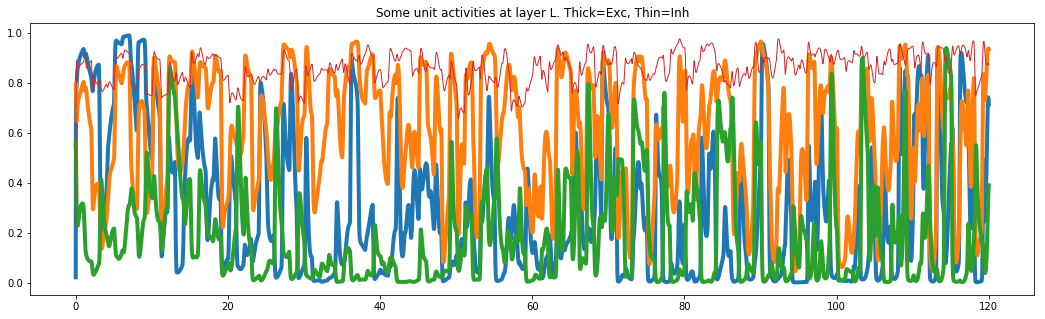

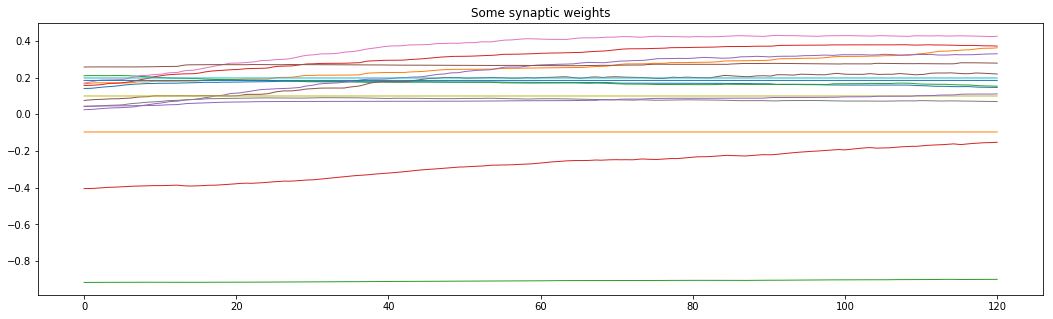

In [37]:
# basic plot 
%matplotlib inline
net_num = 0
net = mp_net_obj.nets[net_num]
L = net.layers['L']
D = net.layers['D']
#shrp = net.layers['shrp']
I1 = net.layers['I1']
I2 = net.layers['I2']
print(L.notes)
net.basic_plot('L')
net.basic_plot('D')

norm of output matrix: 54.129261
norm of input matrix: 43.979793
norm of difference between matrices: 14.117126


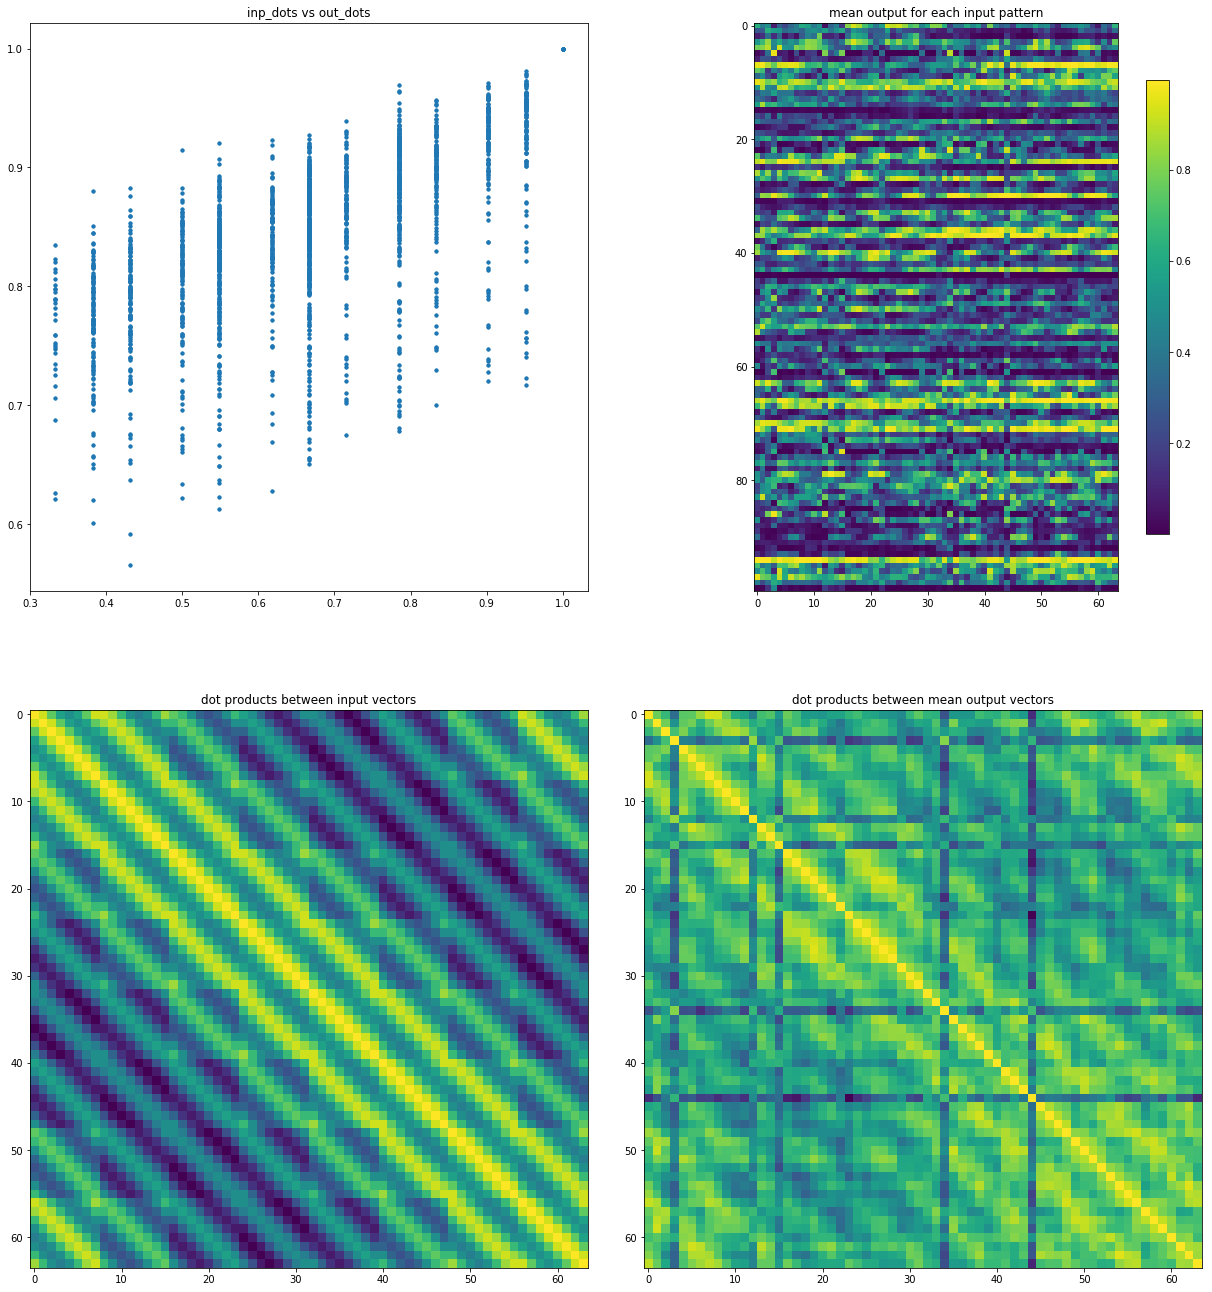

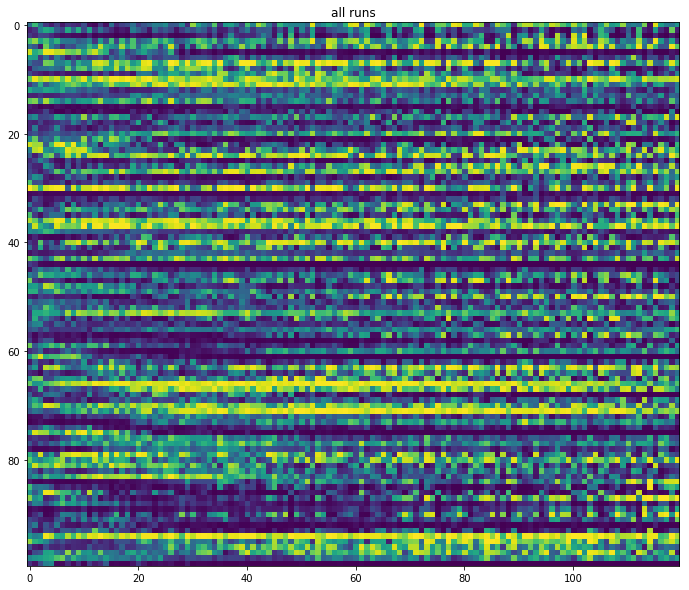

In [38]:
# input-output analysis
mp_net_obj.io_compare(net_num=net_num)

In [16]:
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
net.double_anim(L.e+I1.x+I2.x, slider=True, interv=10, nbins=20, thr=0.7, pdf=True)

interactive(children=(IntSlider(value=10000, description='frame', max=20000, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

norm of error in first part: 23.682084094992284
std dev for desired value (first part): 27.376450331693142
norm of error in second part: 11.670073388452142
std dev for desired value (second part): 13.358577452435599


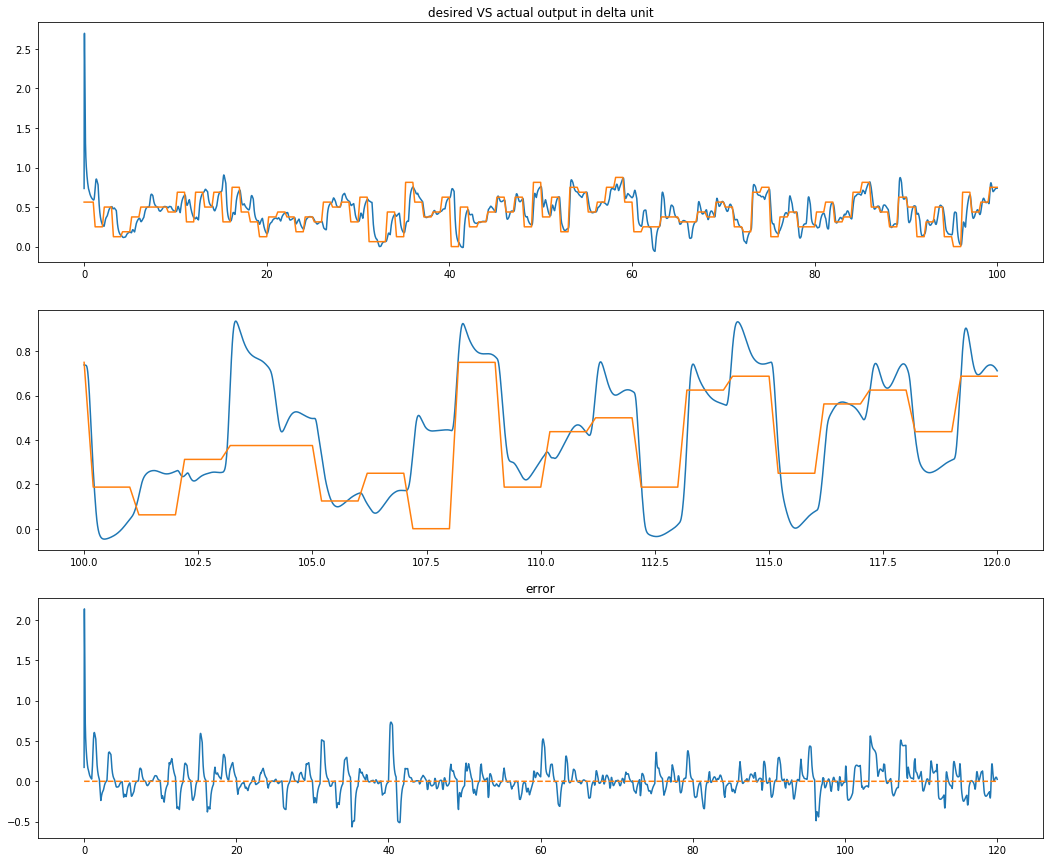

In [39]:
# compare output of the delta unit with the desired output
start_t = 0.
middle_t = 100.
end_t = 120.
mp_net_obj.des_D_compare(start_t, middle_t, end_t, net_num, make_history=False)

[65 35 42]


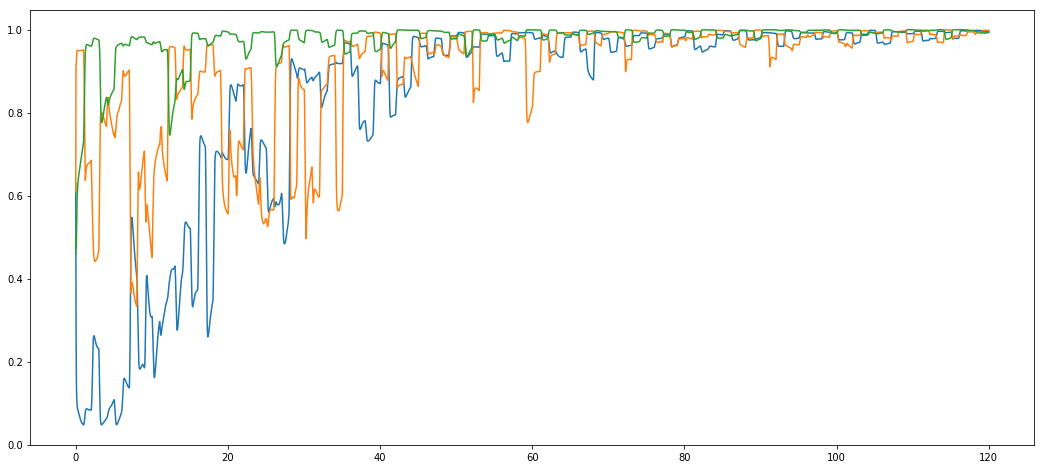

In [35]:
# Plot the highest excitatory unit activities
%matplotlib inline
n_top = 3  # how many units to plot
top_pop = np.array(L.e)  # population to visualize
top_units = net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = net.all_activs[top_pop[top_units]].transpose()
plt.plot(net.all_times, top_acts)
plt.show()

[20 60 57]


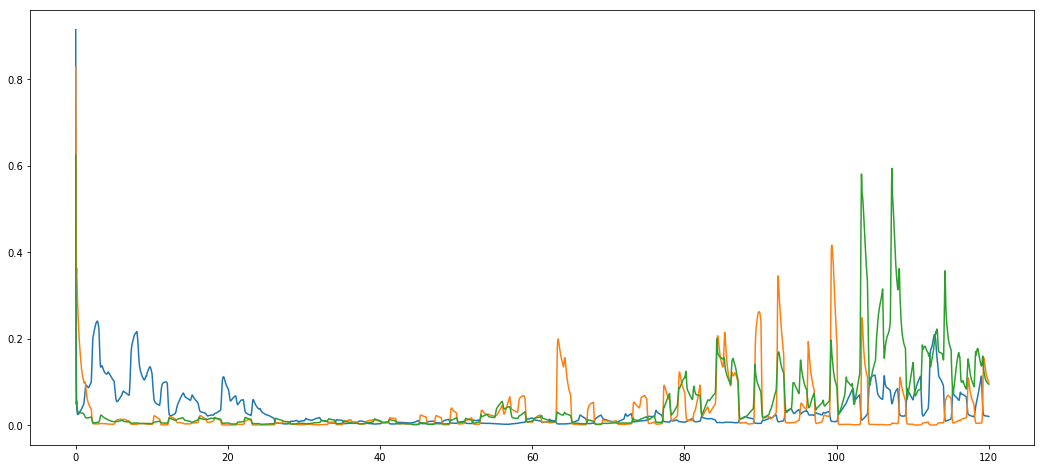

In [36]:
# Plot the lowest excitatory unit activities
n_bottom = 4  # how many units to plot
bottom_pop = np.array(L.e)  # population to visualize
bottom_units = net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(net.all_times, bottom_acts)
plt.show()

In [ ]:
# Annotations for individual networks
net.annotate("This network is very good looking. In the mean output plot you can see units that have the ")
net.annotate("multiplicative modulation, and units that are modulated by a single input! But you can also see")
net.annotate("units that do not move much away from the 0.4 value, and outputs do not go beyond 0.8 .") 
#net.annotate("most responses are between 0.1 and 0.8 .")
#net.annotate("Did not look in detail, but it reminded me of multiplicative modulation.")
#net.annotate("with ei_runner_mp.", make_history=False)
#net.annotate("stop growing.", make_history=False)

In [ ]:
# Visualize the connections
#ei_net.conn_anim(I1.x+I2.x, L.e, slider=False)
net.conn_anim(L.e, L.e, slider=False)

In [ ]:
# Write the configuration of the mp_net_runner object in the simulation log
f = open(log_file, mode='a')
f.write(runner.stdout)
f.close()

In [ ]:
# log all networks
mp_net_obj.log() 

In [ ]:
# saving
for net in mp_net_obj.nets:
    net.history.append('ei_net object being saved in container mp_ei_runner object ' + mp_net_obj.name)
F = open(mp_net_obj.name+'.pkl', 'wb')
dill.dump(mp_net_obj, F)
F.close()

In [5]:
# loading
#F = open("/media/z/data/pickles/exp_dist_sig_test4.pkl", 'rb')
#F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
mp_net_obj = dill.load(F)

In [3]:
mp_net_obj.code = str(runner)

NameError: name 'runner' is not defined

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [42]:
mp_net_obj.nets[4].history

['# ei_network.__init__ at Fri Jul 20 12:28:51 2018',
 'np.random.seed(19680801)',
 '# parallel runner assigned this network the number 4',
 "net_params = {   'atol': 1e-05,\n    'cm_del': 0.01,\n    'min_buff_size': 10,\n    'min_delay': 0.005,\n    'rtol': 1e-05}",
 "layer_names = ['L', 'I1', 'I2']",
 '# ()()()()() Non-default settings: ()()()()()',
 "I1x_Le_conn['connection_type'] = convergent",
 "I1x_Le_conn['number_of_connections'] = 2",
 "I1x_Le_conn['mask'] = {'circular': {'radius': 5.0}}",
 "I1x_Le_conn['kernel'] = {'linear': {'a': 0.5, 'c': 1.0}}",
 "I1x_Le_conn['weights'] = {'uniform': {'high': 0.9, 'low': 0.2}}",
 "I1x_Le_conn['dist_dim'] = y",
 "I1x_Le_conn['edge_wrap'] = False",
 "I1x_Le_syn['inp_ports'] = 1",
 "I1x_Le_syn['type'] = synapse_types.bcm",
 "I1x_Le_syn['lrate'] = 0.01",
 "I1x_Li_conn['connection_type'] = convergent",
 "I1x_Li_conn['number_of_connections'] = 2",
 "I1x_Li_conn['mask'] = {'circular': {'radius': 5.0}}",
 "I1x_Li_conn['kernel'] = {'linear': {'a': 0

In [ ]:
#~~~~~~~~~~~~ mp_net_runner object specification ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        
        """
        self.name = 'exp_dist_sig_test4'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 12  # one per network is good
        self.n_nets = 12
        self.n_pres = [60]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        #dill_obj = dill.load(F)
        #self.nets = dill_obj.nets
        
        layers =  ['L', 'shrp','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('It is seeking good configurations for the sig_ssrdc units, based on step1p2 simulations. ')
            net.annotate('made on 10/13/18 .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sig_ssrdc)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .0)
            L.set_param('e_pars', 'thresh_wid', 0.4)
            L.set_param('e_pars', 'n_ports', 2)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .002)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .002)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 1)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.annotate("Compensating for the ratio of excitatory to inhibitory units.")
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.01}})            
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 2.)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('e_pars', 'des_act', 0.2)
        #----------------------------------
            L.annotate("Using anti_cov_pre EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.anticov_pre)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
         #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', 1.)
            net.set_param('I1x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 1)

            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', 1.)
            net.set_param('I1x_Li_conn', 'weights', {'gaussian' : {'w_center': .3, 'sigma': 2.}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', 1.)
            net.set_param('I2x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 1)

            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', 1.)
            net.set_param('I2x_Li_conn', 'weights', {'gaussian' : {'w_center': .3, 'sigma': 2.}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller tau_scale")
        L.set_param('e_pars', 'tau_scale', .001)
        ### network 2
        n = 2
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller tau_scale, smaller Kp.")
        L.set_param('e_pars', 'tau_scale', 0.001)
        L.set_param('e_pars', 'Kp', 0.01)
        ### network 3
        n = 3
        L.annotate(">>> Smaller tau_scale, larger Kp.")
        L.set_param('e_pars', 'tau_scale', 0.001)
        L.set_param('e_pars', 'Kp', 0.05)
        ### Network 4
        n = 4
        L = self.nets[n].layers['L']
        L.annotate(">>> Larger tau_scale, smaller Kp.")
        L.set_param('e_pars', 'tau_scale', 0.005)
        L.set_param('e_pars', 'Kp', 0.01)
        ### Network 5
        n = 5
        L = self.nets[n].layers['L']
        L.annotate("Removing EI plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 6
        n = 6
        L = self.nets[n].layers['L']
        L.annotate("Removing IE plasticity")
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 7
        n = 7
        L = self.nets[n].layers['L']
        L.annotate("Removing EE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        ### Network 8
        n = 8
        L = self.nets[n].layers['L']
        L.annotate("Removing EI, IE plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 9
        n = 9
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 10
        n = 10
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 11
        n = 11
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        
        self.build()
                      
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I1
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def inp_pat2(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I2
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def make_I1_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat1(pres, rows, columns, net_id, n_pat, random=rnd) 
    
    def make_I2_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat2(pres, rows, columns, net_id, n_pat, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # patterns for L.x
        n_pat0 = 4  # number of input patterns
        self.pat_arr0 = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns
        for row in range(5):
            for col in range(5):
                idx = 5*col + row
                if row == col or row+col == 4: # The X input pattern
                    self.pat_arr0[0,idx] = 1
                if row == 2 or col == 2:  # The + input pattern
                    self.pat_arr0[1,idx] = 1
                if row == 1 or row == 3:  # The = input pattern
                    self.pat_arr0[2,idx] = 1
                if col == 1 or col == 3:  # The || input pattern
                    self.pat_arr0[3,idx] = 1
        self.pat_arr0 = self.pat_arr0 / 5.
        
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            #shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units
            #pats1 = [] # here we'll store id's for the patterns presented by inp_pat1
            #pats2 = [] # here we'll store id's for the patterns presented by inp_pat2
            if self.input_type[idx] == 0:  # for sharpening units
                shrp_inp_pat = lambda p, r, c, n : (1., 1)
                inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True), 
                                'shrp' : shrp_inp_pat }
                inp_fun_dic = {'shrp' : self.set_shrp_fun }
            elif self.input_type[idx] == 1: # for non-sharpening units
                inp_pat_dic = { #'L' : self.inp_pat0,
                                'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True) } 
                inp_fun_dic = {}
            else:
                raise ValueError('Invalid input type for network ' + str(idx))
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
            # you can run just a few nets for debugging purposes...
            #selected = [0, 1, 2] #, 1, 2, 3, 6, 8, 9, 10, 11, 12, 14, 15]
            #sel_nets = [self.nets[n] for n in selected]
            #args = [(n, self.n_pres[n]) for n in selected]
            #sel_nets = pool.map(self.run_net, args)
            #for i,n in enumerate(selected):
            #    self.nets[n] = sel_nets[i]
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
                                
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
# Simulation analysis
net_num = 9
ei_net = mp_net_obj.nets[net_num]
pats1 = ei_net.inp_hist['I1']
pats2 = ei_net.inp_hist['I2']
n_pat1 = ei_net.layers['I1'].n['x']
n_pat2 = ei_net.layers['I2'].n['x']
pres_time = mp_net_obj.pres_t[net_num]
n_pres = mp_net_obj.nets[net_num].present
L = ei_net.layers['L']
inp_pat1 = mp_net_obj.make_I1_inp(n_pat1, False)
inp_pat2 = mp_net_obj.make_I2_inp(n_pat2, False)

## For each input presentation obtain the activity vector from layer L
ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
for pres in range(n_pres):
    for e_idx, idx in enumerate(L.e):
        e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]

# The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
n_pats = len(pats)
pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
for p in range(n_pres):
    p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
    pats[p_id] += 1
    pres_pat[p] = p_id
    
# plot the array of activity patterns
#%matplotlib inline
#ex_fig = plt.figure(figsize=(20,20))
#plt.imshow(e_pats)

# get the mean of output patterns corresponding to the same inputs
mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
for pres in range(n_pres):
    mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
for pat in range(n_pats):
    if pats[pat] > 1:
        mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
# Obtain the angles between any two pairs of input patterns
# get all input patterns
all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
for p1 in range(n_pat1):
    for p2 in range(n_pat2):
        (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
        (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        

# get matrices with dot products between pairs of patterns
inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
inp_norm2 = inp_norm*inp_norm
inp_dots = np.zeros((n_pats, n_pats))
out_dots = np.zeros((n_pats, n_pats))
for p1 in range(n_pats):
    for p2 in range(n_pats):
        inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
        if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                #pres_idx1 = np.argmin(abs(pres_pat - p1))  # index of presentation where you showed pattern 1
                #pres_idx2 = np.argmin(abs(pres_pat - p2))  # index of presentation where you showed pattern 2
                #vec1 = e_pats[:,pres_idx1]  # first input vector
                #vec2 = e_pats[:,pres_idx2]  # second input vector
                vec1 = mean_out[:,p1]
                vec2 = mean_out[:,p2]
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

                
# compare the angles between input patterns with the angles between output patterns
absissae = []
ordinates = []
for row in range(n_pats):
    for column in range(n_pats):
        if out_dots[row,column] > 0:
            absissae.append(inp_dots[row,column])
            ordinates.append(out_dots[row,column])
            
#plot the results of the analysis
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(21, 23))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

im0 = axes[0,0].plot(absissae, ordinates, '.')
axes[0,0].set_title('inp_dots vs out_dots')
im1 = axes[0,1].imshow(mean_out)
axes[0,1].set_title('mean output for each input pattern')
fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
im2 = axes[1,0].imshow(inp_dots)
axes[1,0].set_title('dot products between input vectors')
im3 = axes[1,1].imshow(out_dots)
axes[1,1].set_title('dot products between mean output vectors')
#fig.colorbar(im3,fraction=0.1,shrink=0.8)

fig2 = plt.figure(figsize=(20,10))
plt.imshow(e_pats)
plt.title('all runs')
    
# A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
print("norm of difference between matrices: %f" % (diff_norm))

In [ ]:
# mean activity given the rate distribution
c = 3
a = np.exp(-c)
b = 1-a
mean = (b/c**3)*(1. - (c+1.)*a)
print(mean)

n_points = 1000
r = np.linspace(0.,1.,n_points)
pdf = (b/c)*np.exp(-c*r)
mean2 = np.dot(r,pdf)/n_points
print(mean2)

In [ ]:
for n in range(11):
    mp_net_obj.nets[n+1].log(log_file, False)

In [ ]:
log_file